This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import mannwhitneyu
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 8, 6
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

d:\applications\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Preparing the data
We wish to have a table that looks like:

In [3]:
t = [['student','variable','pre','post','index','sim','CVS table','CVS graph']]
t.append(['s1','v1','1.0','2.333','1','L','Yes','No'])
t.append(['s1','v2','...','...','1','L','Yes','Yes'])
t.append(['s1','v3','...','...','2','C','No','No'])
t.append(['s1','v4','...','...','2','C','Yes','No'])
print tabulate(t)

-------  --------  ---  -----  -----  ---  ---------  ---------
student  variable  pre  post   index  sim  CVS table  CVS graph
s1       v1        1.0  2.333  1      L    Yes        No
s1       v2        ...  ...    1      L    Yes        Yes
s1       v3        ...  ...    2      C    No         No
s1       v4        ...  ...    2      C    Yes        No
-------  --------  ---  -----  -----  ---  ---------  ---------


## Grabing the CVS data...

In [4]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [5]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [6]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)

table_cvs_df2['sum caps'] = table_cvs_df2[['Area','Separation']].sum(axis=1)
table_cvs_df2['sum light'] = table_cvs_df2[["Width","Concentration"]].sum(axis=1)

graph_cvs_df2['sum caps'] = graph_cvs_df2[['Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light'] = graph_cvs_df2[["Width","Concentration"]].sum(axis=1)
table_cvs_df2.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order,sum,sum caps,sum light
0,11612162,0,0,0,1,1,1,CL,3,0,2
1,13660166,0,0,0,0,0,1,LC,1,0,1
2,41947147,1,0,0,1,1,1,CL,4,0,2
3,64006159,0,0,0,1,0,1,LC,2,0,1
4,15749160,0,1,1,0,1,1,CL,4,2,2


In [7]:
table_intervals_df = pd.read_csv('table_intervals_results.txt', sep='\t')

## Grabbing the worksheet data

In [8]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
main = get_main_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [9]:
## make desired table for beers
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='main')

L_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
L_scores['sim'] = 'L'

L_scores['CVS_table'] = L_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph'] = L_scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['sim_index'] = L_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [10]:
# L_scores.sort_values('sid').head()

In [11]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('caps')
pre = get_pre_worksheet(sim='caps')
main = get_main_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [12]:
## make desired table for caps
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='main')

C_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
C_scores['sim'] = 'C'

C_scores['CVS_table'] = C_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph'] = C_scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['sim_index'] = C_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [22]:
data = pd.concat([L_scores,C_scores])
data['intervals_in_table'] = data.apply(lambda row: table_intervals_df.loc[table_intervals_df[table_intervals_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data = data.reset_index(drop=True)
data.sort_values('sid').head(12)

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index,intervals_in_table,CVS_table_only
0,10127163,Concentration,1.0,3.0,L,1,1,1,True,0
148,10127163,Width,1.0,3.0,L,1,1,1,False,0
296,10127163,Area,3.0,3.0,C,1,1,2,False,0
444,10127163,Separation,3.0,3.0,C,1,1,2,False,0
538,10192168,Separation,1.0,2.0,C,1,1,1,False,0
96,10192168,Concentration,1.0,3.0,L,1,1,2,False,0
390,10192168,Area,1.0,2.0,C,1,0,1,False,1
244,10192168,Width,1.0,0.0,L,1,0,2,True,1
1,10232160,Concentration,1.0,1.0,L,1,1,1,False,0
149,10232160,Width,1.0,1.0,L,0,0,1,False,0


## Stats tools and multicollinearity check

In [23]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [24]:
from scipy import stats
print "Correlation coeff for table and graph CVS:", stats.spearmanr(data['CVS_table'],data['CVS_graph'])
print "Correlation coeff for table only and graph CVS:", stats.spearmanr(data['CVS_table_only'],data['CVS_graph'])

Correlation coeff for table and graph CVS: SpearmanrResult(correlation=0.61892063046789791, pvalue=6.9922209879042454e-64)
Correlation coeff for table only and graph CVS: SpearmanrResult(correlation=-0.52927663743068099, pvalue=4.7870201806510133e-44)


Let's measure the variance inflation factor of including both CVS table and graph in the same models:

In [25]:
formula = 'CVS_table_only ~ CVS_graph + pre + C(variable) + C(sim_index) + C(sim) '
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.params

model:  CVS_table_only ~ CVS_graph + pre + C(variable) + C(sim_index) + C(sim)  

         Current function value: 0.344469
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         CVS_table_only   No. Observations:                  592
Model:                          Logit   Df Residuals:                      585
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Jan 2018   Pseudo R-squ.:                  0.3534
Time:                        23:26:46   Log-Likelihood:                -203.93
converged:                      False   LL-Null:                       -315.39
                                        LLR p-value:                 2.481e-45
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                 

d:\applications\anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\applications\anaconda2\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [26]:
R2 = 0.3534
VIF = 1.0/(1-R2)
VIF

1.5465511908444167

A VIF of 1.55 tells us that the variance (the square of the standard error) of a particular coefficient is 55% larger than it would be if that predictor was completely uncorrelated with all the other predictors. According to [this website](https://statisticalhorizons.com/multicollinearity), a VIF of 2.6 or higher is worrisome.

# Results to present in methods
## Student population

In [28]:
N = len(set(data['sid']))
print "The study includes {0} students".format(N)

The study includes 148 students


In [29]:
print 'Gender distribution'

Gender distribution


## Student prior experience

In [30]:
print 'Undergraduate year level'

Undergraduate year level


In [31]:
print 'Lab courses taken in pphysics and chemistry'

Lab courses taken in pphysics and chemistry


In [32]:
print 'experience in virtual labs in general'

experience in virtual labs in general


In [33]:
print  'experience in virutal labs teaching light absorbance or capacitors before'

experience in virutal labs teaching light absorbance or capacitors before


# Learning through inquiry
## Overall

Let's look at pre to post to see if students learn.

Right now we have 4 entries per student and add "variable" to the model. But then pre matters (p=0.04)
But we could have main = mean(var1 and var 2 scores). In which case pre doesn't matter (p=0.056)
Either way with tiny effect size.

In [34]:
scores = pd.pivot_table(data, values=['pre','main'], index=['sim','sid'],aggfunc=np.mean)
scores.reset_index(level=0, inplace=True)
scores['sid']=scores.index
scores.index = scores['sim']

In [35]:
t = [['sim','pre','post','U','p','effect size']]
for sim in ['L','C']:
    pm = round(np.mean(scores.loc[sim]['pre']),2)
    ps = round(np.std(scores.loc[sim]['pre']),2)
    mm = round(np.mean(scores.loc[sim]['main']),2)
    ms = round(np.std(scores.loc[sim]['main']),2)
    U,p = mannwhitneyu(scores.loc[sim]['pre'],scores.loc[sim]['main'])
    eta = round(1-U/(N*N),2)
    t.append([sim,str(pm)+'+/-'+str(ps),str(mm)+'+/-'+str(ms),U,p,eta])
    
pU,pp = mannwhitneyu(scores.loc['L']['pre'],scores.loc['C']['pre'])
mU,mp = mannwhitneyu(scores.loc['L']['main'],scores.loc['C']['main'])
peta = round(1-pU/(N*N),2)
meta = round(1-mU/(N*N),2)
t.append(['U',pU,mU,'','',''])
t.append(['p',pp,mp,'','',''])
t.append(['effect size',peta,meta,'','',''])
print tabulate(t)

-----------  --------------  ---------------  ------  -----------------  -----------
sim          pre             post             U       p                  effect size
L            1.17+/-0.69     2.35+/-0.63      2647.0  1.52951994175e-31  0.88
C            1.28+/-0.67     2.24+/-0.63      3167.0  7.28789989597e-28  0.86
U            9610.0          9890.5
p            0.028724020555  0.0608548196149
effect size  0.56            0.55
-----------  --------------  ---------------  ------  -----------------  -----------


Overall, student learn in both sims. Prior knowledge is significantly higher in capacitor lab but post is similar.

# Does using strategy help student learn?

Because CVS_table and CVS_graph are related, we need to create a CVS_table_only paramter to avoid multicollinearity in our model.

## Using either CVS and learning

In [36]:
formula = 'main ~ C(CVS_graph) + C(CVS_table_only) + variable + pre + C(sim_index)*C(sim) + C(sid)'# + pre*C(sim)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Anova table using type 2 errors"
print(aov_table)

Model:  main ~ C(CVS_graph) + C(CVS_table_only) + variable + pre + C(sim_index)*C(sim) + C(sid)
Anova table using type 2 errors
                      sum_sq     df       F     PR(>F)  eta_sq   omega_sq
C(CVS_graph)           4.365    1.0  15.725  8.555e-05   0.016  1.510e-02
C(CVS_table_only)      0.296    1.0   1.066  3.024e-01   0.001  6.785e-05
variable               2.349    3.0   2.821  3.860e-02   0.009  5.602e-03
C(sim_index)           3.753    1.0  13.519  2.655e-04   0.014  1.284e-02
C(sim)                 0.533    1.0   1.921  1.664e-01   0.002  9.451e-04
C(sid)               135.939  147.0   3.331  2.601e-22   0.503  3.516e-01
C(sim_index):C(sim)    0.972    1.0   3.502  6.195e-02   0.004  2.567e-03
pre                    0.819    1.0   2.951  8.656e-02   0.003  2.001e-03
Residual             121.304  437.0     NaN        NaN     NaN        NaN


Variable matters (will need to investigate). Order\*sim matter, but not sim alone. CVS table doesn't matter but graph does!

## Investigating CVS table and interval usage

In [39]:
formula = 'main ~ C(CVS_table_only)*C(intervals_in_table) + variable + pre + C(sim_index)*C(sim) + C(sid)'# + pre*C(sim)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Anova table using type 2 errors"
print(aov_table)

Model:  main ~ C(CVS_table_only)*C(intervals_in_table) + variable + pre + C(sim_index)*C(sim) + C(sid)
Anova table using type 2 errors
                                          sum_sq     df       F     PR(>F)     eta_sq   omega_sq
C(CVS_table_only)                          0.154    1.0   0.534  4.653e-01  5.337e-04 -4.653e-04
C(intervals_in_table)                      0.008    1.0   0.027  8.701e-01  2.674e-05 -9.718e-04
variable                                   3.248    3.0   3.762  1.092e-02  1.128e-02  8.273e-03
C(sim_index)                               5.465    1.0  18.989  1.641e-05  1.898e-02  1.796e-02
C(sim)                                     0.671    1.0   2.330  1.276e-01  2.329e-03  1.328e-03
C(sid)                                   149.960  147.0   3.545  1.498e-24  5.208e-01  3.735e-01
C(CVS_table_only):C(intervals_in_table)    0.189    1.0   0.657  4.180e-01  6.567e-04 -3.424e-04
C(sim_index):C(sim)                        1.540    1.0   5.350  2.119e-02  5.347e-03  4.

## Breaking it down by variable
### Width

In [43]:
variable = 'Width'
formula = 'main ~ C(CVS_table_only) + C(CVS_graph) + pre + C(sim_index)*C(sim)'# + pre*C(sim)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data[data['variable']==variable]).fit()
print model.summary()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "Anova table using type 2 errors"
# print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     8.183
Date:                Tue, 16 Jan 2018   Prob (F-statistic):           5.69e-06
Time:                        23:29:50   Log-Likelihood:                -152.90
No. Observations:                 148   AIC:                             315.8
Df Residuals:                     143   BIC:                             330.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

### Concentration

In [45]:
variable = 'Concentration'
formula = 'main ~ C(CVS_table_only) + C(CVS_graph) + pre + C(sim_index)*C(sim)'# + pre*C(sim)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data[data['variable']==variable]).fit()
print model.summary()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "Anova table using type 2 errors"
# print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     9.025
Date:                Tue, 16 Jan 2018   Prob (F-statistic):           1.58e-06
Time:                        23:30:38   Log-Likelihood:                -128.08
No. Observations:                 148   AIC:                             266.2
Df Residuals:                     143   BIC:                             281.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

### Area

In [47]:
variable = 'Area'
formula = 'main ~ C(CVS_table_only) + C(CVS_graph) + pre + C(sim_index)*C(sim)'# + pre*C(sim)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data[data['variable']==variable]).fit()
print model.summary()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "Anova table using type 2 errors"
# print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     7.199
Date:                Tue, 16 Jan 2018   Prob (F-statistic):           2.61e-05
Time:                        23:30:56   Log-Likelihood:                -145.21
No. Observations:                 148   AIC:                             300.4
Df Residuals:                     143   BIC:                             315.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

### Separation

In [50]:
variable = 'Separation'
formula = 'main ~ C(CVS_table_only) + C(CVS_graph) + pre + C(sim_index)*C(sim)'# + pre*C(sim)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data[data['variable']==variable]).fit()
print model.summary()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "Anova table using type 2 errors"
# print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.943
Date:                Tue, 16 Jan 2018   Prob (F-statistic):            0.00457
Time:                        23:32:07   Log-Likelihood:                -145.47
No. Observations:                 148   AIC:                             300.9
Df Residuals:                     143   BIC:                             315.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

It seems like doing CVS plotting helps students model the variable (by varying amounts given by the confidence intervals) for all variables but not for Separation. Students who succeed in modeling separation probably bring in another skill that the sim doesn't support, or learn to use the axis scales (-> future directions)

I don't understand why prior knowledge all of a sudden matters here, with large confidence intervals for Capacitance variables, and not significant for Width... this is very confusing.

# How do students use CVS-like inquiry strategies in a PhET sim activity?

For some reason adding students in the matric turns it into a singular matrix and fails the analysis. Probably because two students are exactly identical?

## Are students consistent in their use accross sims?
### CVS collecting consistency

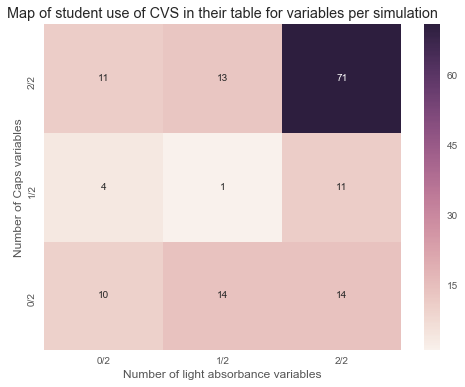

In [51]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their table for variables per simulation')

High proficiency is consistent
### CVS plotting consistency

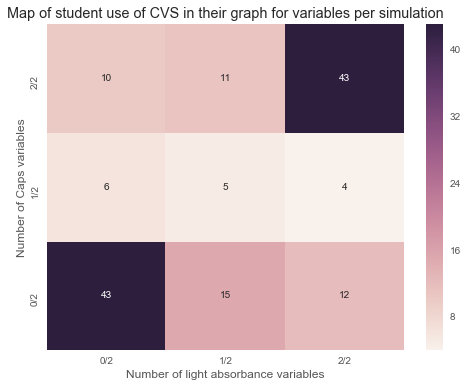

In [52]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

High usage is consistent. If they do CVS with 1 variable in one sim, they do it with 2 in the other (probaly second sim).We'll see how order makes a difference later.

## How does incoming knowledge affect doing CVS
### For CVS collection

In [60]:
formula = 'CVS_table_only ~ pre*C(variable) + C(sim_index)*C(sim) '
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.params

model:  CVS_table_only ~ pre*C(variable) + C(sim_index)*C(sim)  

Optimization terminated successfully.
         Current function value: 0.526938
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         CVS_table_only   No. Observations:                  592
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            9
Date:                Tue, 16 Jan 2018   Pseudo R-squ.:                 0.01090
Time:                        23:37:26   Log-Likelihood:                -311.95
converged:                       True   LL-Null:                       -315.39
                                        LLR p-value:                    0.6500
                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

Clearly pre doesn't matter, neither does the variable. CVS is more likely in the second sim (no surprise there), especially if second sim is capacitance (only significant interaction).

### For CVS plotting

In [61]:
formula = 'CVS_graph ~ pre*C(variable) + C(sim_index)*C(sim) '
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.params

model:  CVS_graph ~ pre*C(variable) + C(sim_index)*C(sim)  

Optimization terminated successfully.
         Current function value: 0.671971
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            9
Date:                Tue, 16 Jan 2018   Pseudo R-squ.:                 0.03035
Time:                        23:37:45   Log-Likelihood:                -397.81
converged:                       True   LL-Null:                       -410.26
                                        LLR p-value:                  0.003079
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Int

CVS plotting occurs more in second sim but no interaction with sim type. Pre doesn't matter, variable doesn't matter.

# Is there learning of CVS?

## Consistency over time: proficient users of strategy are consistent, less proficient are less consistent

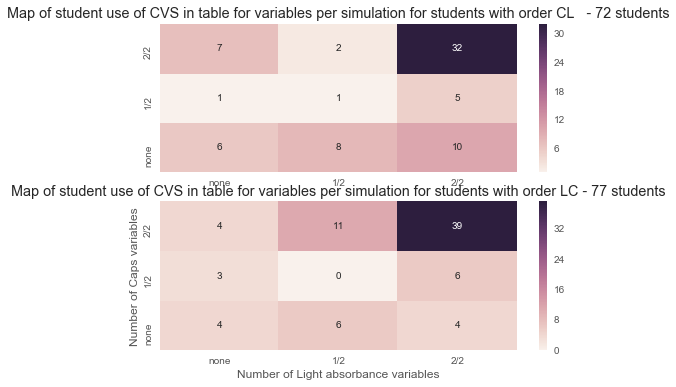

In [62]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light']==j)&(table_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order CL   - {0} students'.format(len(table_cvs_df2[table_cvs_df2['activity order']=='CL'])))

ax = ax2
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light']==j)&(table_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order LC - {0} students'.format(len(table_cvs_df2[table_cvs_df2['activity order']=='LC'])))

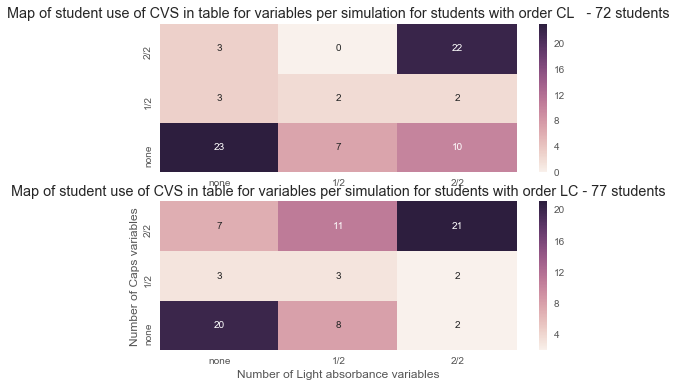

In [63]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light']==j)&(graph_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order CL   - {0} students'.format(len(graph_cvs_df2[graph_cvs_df2['activity order']=='CL'])))

ax = ax2
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light']==j)&(graph_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order LC - {0} students'.format(len(graph_cvs_df2[graph_cvs_df2['activity order']=='LC'])))

High usage and no usage (in graph) is consistent. More likely to do CVS in second sim

## Can we predict use of CVS?
### Learning to do CVS collect

First we have to collapse the data to what students did in their first and second sim

In [64]:
cvs_learn = pd.pivot_table(data, values=['pre','main','CVS_table'], index=['sim_index','sid'],aggfunc=np.sum)
cvs_learn.reset_index(level=0, inplace=True)
cvs_learn['main']=cvs_learn['main']/2
cvs_learn['pre']=cvs_learn['pre']/2
cvs_learn_1 = cvs_learn[cvs_learn['sim_index']==1]
cvs_learn_1.columns = ['sim_index','CVS_table_1', 'main_1', 'pre_1']
cvs_learn_2 = cvs_learn[cvs_learn['sim_index']==2]
cvs_learn_2.columns = ['sim_index','CVS_table_2', 'main_2', 'pre_2']
cvs_learn = pd.concat([cvs_learn_1,cvs_learn_2],axis=1)
cvs_learn['sid'] = cvs_learn.index
cvs_learn['first_sim'] = cvs_learn['sid'].apply(lambda sid: list(data[(data['sid']==sid)&(data['sim_index']==1)]['sim'])[0])
cvs_learn = cvs_learn[['CVS_table_1','main_1','pre_1','CVS_table_2','first_sim']]
cvs_learn.head()

,CVS_table_1,main_1,pre_1,CVS_table_2,first_sim
sid,,,,,
10127163,2,3.0,1.0,2,L
10192168,2,2.0,1.0,2,C
10232160,1,1.0,1.0,2,L
10375163,2,3.0,1.0,2,C
10420167,2,2.5,2.0,2,C


In [65]:
formula = 'CVS_table_2 ~ CVS_table_1*main_1 + pre_1 + C(first_sim)'
model = ols(formula, cvs_learn).fit()
# print model.summary()
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Anova table using type 2 errors"
print(aov_table)

Model:  CVS_table_2 ~ CVS_table_1*main_1 + pre_1 + C(first_sim)
Anova table using type 2 errors
                    sum_sq     df       F     PR(>F)     eta_sq   omega_sq
C(first_sim)         0.009    1.0   0.016  8.996e-01  9.775e-05 -5.986e-03
CVS_table_1          6.798    1.0  12.522  5.439e-04  7.664e-02  7.009e-02
main_1               0.479    1.0   0.883  3.489e-01  5.405e-03 -7.111e-04
CVS_table_1:main_1   4.106    1.0   7.564  6.728e-03  4.630e-02  3.993e-02
pre_1                0.216    1.0   0.398  5.290e-01  2.437e-03 -3.661e-03
Residual            77.083  142.0     NaN        NaN        NaN        NaN


Student who uses CVS collect previously were more likely to do so again, and even more so depending on how much they learned! (need to investigate further if its learn more do more or not).

The first sim doesn't matter surprisingly.

## Learning to do CVS plot

In [66]:
data.head()

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index,intervals_in_table,CVS_table_only
0,10127163,Concentration,1.0,3.0,L,1,1,1,True,0
1,10232160,Concentration,1.0,1.0,L,1,1,1,False,0
2,10537160,Concentration,1.0,2.0,L,1,0,2,False,1
3,10375163,Concentration,0.0,2.0,L,1,0,2,False,1
4,10420167,Concentration,1.0,3.0,L,1,1,2,False,0


In [67]:
cvs_learn = pd.pivot_table(data, values=['pre','main','CVS_graph','CVS_table_only'], index=['sim_index','sid'],aggfunc=np.sum)
cvs_learn.reset_index(level=0, inplace=True)
cvs_learn['main']=cvs_learn['main']/2
cvs_learn['pre']=cvs_learn['pre']/2
cvs_learn_1 = cvs_learn[cvs_learn['sim_index']==1]
cvs_learn_1.columns = ['sim_index','CVS_graph_1','CVS_table_only_1', 'main_1', 'pre_1']
cvs_learn_2 = cvs_learn[cvs_learn['sim_index']==2]
cvs_learn_2.columns = ['sim_index','CVS_graph_2','CVS_table_only_2', 'main_2', 'pre_2']
cvs_learn = pd.concat([cvs_learn_1,cvs_learn_2],axis=1)
cvs_learn['sid'] = cvs_learn.index
cvs_learn['first_sim'] = cvs_learn['sid'].apply(lambda sid: list(data[(data['sid']==sid)&(data['sim_index']==1)]['sim'])[0])
# cvs_learn.head()

In [68]:
formula = 'CVS_graph_2 ~ CVS_graph_1*main_1 + CVS_table_only_1 + pre_1 + C(first_sim)'
model = ols(formula, cvs_learn).fit()
# print model.summary()
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Anova table using type 2 errors"
print(aov_table)

Model:  CVS_graph_2 ~ CVS_graph_1*main_1 + CVS_table_only_1 + pre_1 + C(first_sim)
Anova table using type 2 errors
                    sum_sq     df       F     PR(>F)     eta_sq  omega_sq
C(first_sim)         0.006    1.0   0.010  9.223e-01  5.452e-05    -0.006
CVS_graph_1         19.211    1.0  30.213  1.761e-07  1.727e-01     0.166
main_1               1.168    1.0   1.836  1.776e-01  1.050e-02     0.005
CVS_graph_1:main_1   0.046    1.0   0.073  7.873e-01  4.177e-04    -0.005
CVS_table_only_1     0.971    1.0   1.527  2.186e-01  8.729e-03     0.003
pre_1                0.176    1.0   0.277  5.998e-01  1.581e-03    -0.004
Residual            89.658  141.0     NaN        NaN        NaN       NaN


Again, sim doesn't matter.

Only doing CVS graph does, regardless of if they learned from it or not!